<a href="https://colab.research.google.com/github/mayankles/wikipedia_philosopy_network/blob/main/Wikipedia_first_link_crawler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crawling Wikipedia with ChatGPT

I wanted to play with the [Getting to Philosophy](https://en.wikipedia.org/wiki/Wikipedia:Getting_to_Philosophy) phenomenon, so I asked ChatGPT4 for help.  It had its ups and downs, but overall it was a fantastic and illuminating experience working with an AI assistant!

You can read the conversation I had with ChatGPT to create most of the code in this notebook at [this link](https://chat.openai.com/share/87ea3ecf-b2f4-44ff-a24b-aec5df7a816d)

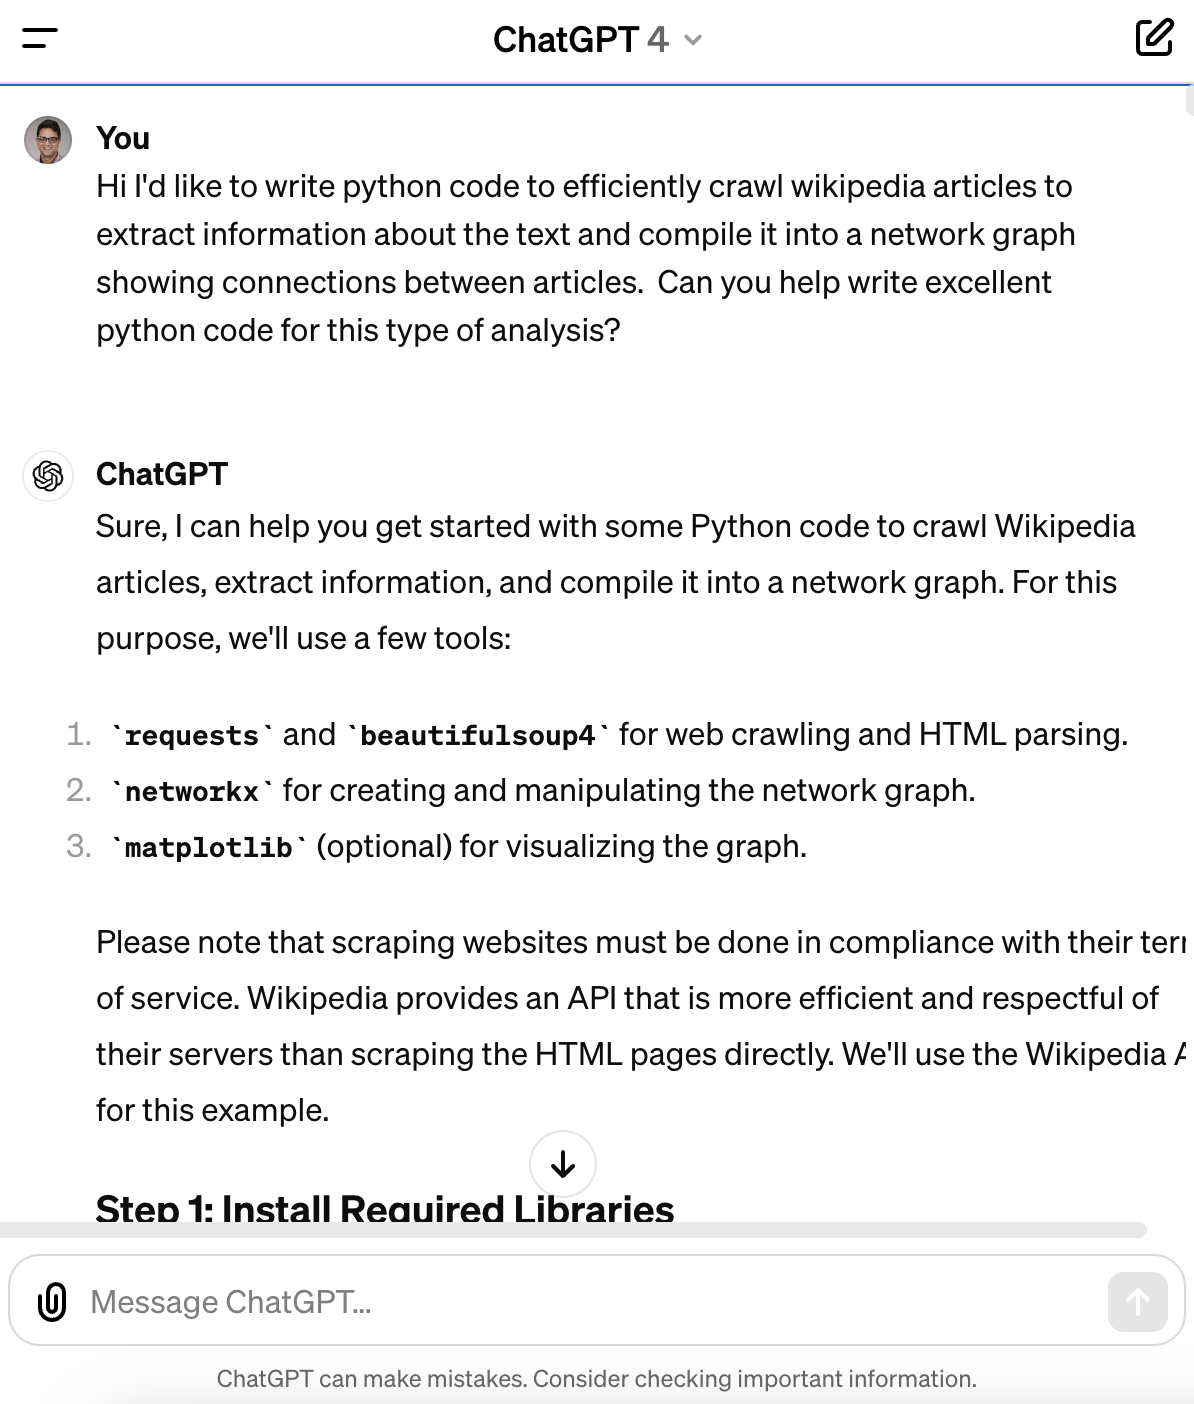

---

# Working prototype
Since ChatGPT cannot currently run python code, I needed to ask it to write code, read it to see if it generally did what I wanted, fiddle around with it in a Python Notebook, troubleshoot, and then come back to ChatGPT for implementation orsuggestions for fixes. Here is ChatGPT's description of what the code does:

<blockquote>

The code you've shared is designed to crawl Wikipedia in a specific manner, following the "first link" rule in the main text of articles. This rule often leads to a philosophical concept known as "getting to Philosophy," where, if you keep following the first non-parenthesized, non-italicized link in the main text of Wikipedia articles, you'll eventually end up on the "Philosophy" page. Here's a breakdown of what each part of the code does:

### `get_article_html_from_title(page_title)`

This function fetches the HTML content of a Wikipedia article given its title. It makes a request to the Wikipedia API with the article's title, asking for the page's parsed text (HTML), and returns the JSON response.

### `get_first_valid_link(page_source)`

Given the title of a Wikipedia article, this function:
- Retrieves the article's HTML content using `get_article_html_from_title`.
- Parses the HTML to find the first valid hyperlink that is not in parentheses and does not lead to an external site or a reference within the same page. 
- If the article is a redirect page, it finds and returns the title of the target article.
- It carefully navigates through the text to avoid links within parentheses, using a stateful approach to handle nested parentheses.
- Returns the title of the first linked Wikipedia article it finds in the main body text.

### `crawl_wikipedia(start_article, max_iterations=100)`

This is the main function that:
- Starts with a given Wikipedia article and crawls to the first valid link found within that article's text.
- Continues this process, following the chain of first links from article to article.
- Stops if it encounters a loop (i.e., a previously visited article) or reaches a specified maximum number of iterations to prevent infinite loops.
- Compiles a dictionary mapping each article to the first link found within its text, effectively tracing the path taken through Wikipedia.
- Optionally prints the total number of topics parsed and the duration of the crawl for performance monitoring.

### Usage

The example usage demonstrates how to start the crawl from the "Mathematics" article and follow up to 50 iterations, printing each article and its first link, along with the total number of articles parsed and the time taken to complete the crawl.

### Summary

In essence, this code navigates through Wikipedia in a deterministic way based on the "first link" rule, offering insights into the structure of Wikipedia's article network and how topics are interlinked. This kind of analysis can reveal interesting patterns about the distribution of knowledge across Wikipedia and how different topics are related.
</blockquote>

In [ ]:
import requests
import gzip
import json
import datetime
from bs4 import BeautifulSoup, NavigableString



def get_article_html_from_title(page_title):
    session = requests.Session()
    URL = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "parse",
        "page": page_title,
        "format": "json",
        "prop": "text"
    }

    response = session.get(url=URL, params=params)
    data = response.json()
    return data

def get_first_valid_link(page_source):
    """Fetch the first link in a Wikipedia article's HTML content, ignoring text in parentheses and excluding links within tables."""

    data = get_article_html_from_title(page_source)
    if data is None:
        print("Failed to retrieve article data.")
        return None

    if "parse" not in data:
        print("parse not in data")
        return None

    # Extract HTML content from the JSON structure
    html_content = data["parse"]["text"]["*"]
    soup = BeautifulSoup(html_content, "html.parser")

    # Check for a redirect message
    redirect_msg = soup.find("div", class_="redirectMsg")
    if redirect_msg:
        redirect_link = redirect_msg.find("li").find("a", href=True)
        if redirect_link:
            return redirect_link['href'].split("/wiki/")[1]  # Return the title of the redirect target

    # Read through each paragraph, skipping any that are inside tables
    for p in soup.find_all("p"):
        if p.find_parent("table"):
            continue  # Skip paragraphs that are inside a table

        # Initialize a flag to track whether we're inside parentheses
        in_parentheses = False
        parentheses_depth = 0  # Track the depth of nested parentheses

        for child in p.children:
            if isinstance(child, NavigableString):
                for char in child:
                    if char == '(':
                        in_parentheses = True
                        parentheses_depth += 1
                    elif char == ')' and parentheses_depth > 0:
                        parentheses_depth -= 1
                        if parentheses_depth == 0:
                            in_parentheses = False
            elif child.name == "a" and "href" in child.attrs and not in_parentheses:
                link_href = child.attrs["href"]
                if link_href.startswith("/wiki/") and not ":" in link_href:
                    link_title = link_href.split("/wiki/")[1]
                    return link_title

    return None

def crawl_wikipedia(start_article, max_iterations=100, printLive=True):
    """
    Crawl Wikipedia starting from a given article, following the first valid link in each article,
    until a loop is detected or a maximum number of iterations is reached.

    :param start_article: The title of the Wikipedia article to start the crawl.
    :param max_iterations: The maximum number of iterations to prevent infinite loops.
    :return: A dictionary mapping each article to its first link.
    """
    articles_and_links = {}
    current_article = start_article

    for _ in range(max_iterations):
        if current_article in articles_and_links:
            # We've encountered a loop or a previously visited article
            break

        # Get the first valid link from the current article
        first_link = get_first_valid_link(current_article)
        # first_link = get_first_valid_link_optimized(current_article)
        if first_link is None:
            # No valid links found, end the crawl
            print("No valid first link found for: " + current_article)
            break

        # Store the result and prepare for the next iteration
        if printLive:
          print(f"{current_article} -> {first_link}")
        articles_and_links[current_article] = first_link
        current_article = first_link

    return articles_and_links

# import datetime
# # Example usage
start_article = "Constitution of the United States"
# start_article = "Philosophy"
# start_article = "Government"
# # start_article = "Mathematics"
# start_article = "Artificial intelligence"
# start_article = "Jupiter"
# start_article = "Joe Rogan"
# start_article = "genetics"
# start_article = "Microsoft"
# start_article = "Pyramids"
# start_article = "Poop"
# start_article = "The Beatles"
# start_article = "Construction"
# start_article = "efflorescence"
# start_article = "ChatGPT"
# start_article = "Marvel Comics"
# start_article = "Metadata"
# start_article = "Consciousness"
# start_article = "Ashoka"
# start_article = "Dumbass"
# start_article = "Passion of the Christ"
# start_article = "Hunter Biden"
# start_article = "candy corn"
# start_article = "Brazil"
# start_article = "Glenn Greenwald"
# start_article = "saddle"
# start_article = "Dyson sphere"
# start_article = "Finance"

starttime=datetime.datetime.now()
articles_links_dict = crawl_wikipedia(start_article, max_iterations=50)
# for article, first_link in articles_links_dict.items():
#     print(f"{article} -> {first_link}")

endtime=datetime.datetime.now()

print("Topics parsed: " + str(len(articles_links_dict)))
print("Time elapsed: " + str(endtime-starttime))

Constitution of the United States -> Supremacy_Clause
Supremacy_Clause -> Constitution_of_the_United_States
Constitution_of_the_United_States -> Supremacy_Clause
Topics parsed: 3
Time elapsed: 0:00:02.828170


# Visualization

Plotting individual first-link paths using networkx...


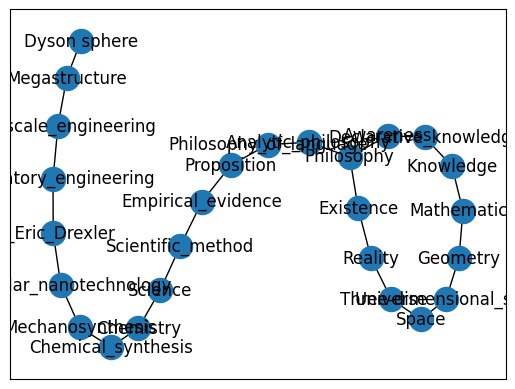

In [ ]:
# prompt: an interactive graph of each connection as it prints out

import networkx as nx
import matplotlib.pyplot as plt

# Initialize the graph
G = nx.Graph()

# Iterate through the dictionary and add nodes and edges
for article, first_link in articles_links_dict.items():
    # Add nodes if they don't already exist
    if article not in G.nodes:
        G.add_node(article)
    if first_link not in G.nodes:
        G.add_node(first_link)

    # Add the edge between the current article and its first link
    G.add_edge(article, first_link)

# Draw the graph
nx.draw_networkx(G, with_labels=True)
plt.show()


pos = nx.nx_agraph.graphviz_layout(G, prog="twopi", args="")
plt.figure(figsize=(12, 12))
nx.draw(G, pos, node_size=20, alpha=0.5, node_color="blue", with_labels=False)
plt.axis("equal")
plt.show()


# Moar data

When I started getting bored to coming up with topics to search for, I asked ChatGPT to generate some, then more,...


In [ ]:
# prompt: run crawl_wikipedia for a list of 100 randomly generated article titles and save a global dictionary of all title-link pairs

import random

# List of random article titles **generated by ChatGPT4 lol***
random_article_titles = [
    "Global Warming", "Taj Mahal", "History of Pizza", "Digital Photography", "Artificial Photosynthesis",
    "Moby Dick", "Impressionism", "The Silk Road", "Electric Car", "Theory of Relativity",
    "Plate Tectonics", "Shakespeare", "Mayan Civilization", "Podcasting", "Black Holes",
    "Cyber Security", "Ancient Olympics", "Coral Reefs", "Sonar Technology", "Jazz Music",
    "French Revolution", "Blockchain Technology", "Human Genome Project", "Mars Rover", "Quantum Computing",
    "Chernobyl Disaster", "Great Wall of China", "Artificial Intelligence", "Cryptocurrency", "The Beatles",
    "Einstein", "Biodiversity", "Sustainable Energy", "Venice", "Leonardo da Vinci",
    "3D Printing", "Origins of Language", "Machu Picchu", "Microbiome", "Nanotechnology",
    "Vikings", "Sphinx of Giza", "Wind Power", "Machine Learning", "Pablo Picasso",
    "Heart Surgery", "Antarctica", "Cleopatra", "Gene Editing", "World War I",
    "The Internet", "Drone Warfare", "Renaissance Art", "Climate Change", "Snowboarding",
    "Deep Sea Exploration", "Autonomous Vehicles", "Cognitive Science", "Virtual Reality", "The Sun",
    "Haiku Poetry", "Nile River", "Galileo Galilei", "Bitcoin", "Skyscrapers",
    "Dark Matter", "Archimedes", "Hip Hop Music", "Video Game Development", "Pandas",
    "Great Depression", "Dream Interpretation", "King Arthur", "Photosynthesis", "Data Encryption",
    "Mount Everest", "Wine Making", "Socrates", "J.R.R. Tolkien", "Neuroplasticity",
    "Dinosaurs", "Acupuncture", "Titanic", "Solar Power", "The Louvre",
    "Nobel Prize", "Kafka", "Cricket", "Yoga", "Napoleon Bonaparte",
    "Beethoven", "Laser", "Aurora Borealis", "Big Bang Theory", "Alchemy",
    "Pyramids of Egypt", "Quantum Mechanics", "Nostradamus", "Veganism", "Zodiac Signs",
    "Holography", "Wildebeests", "Telepathy", "Gandhi", "Linguistics"
]


# Initialize global dictionary
global_article_links_dict = {}

# Crawl Wikipedia for each random article title
for article_title in random_article_titles:
    articles_links_dict = crawl_wikipedia(article_title, max_iterations=50, printLive=False)
    global_article_links_dict.update(articles_links_dict)

# Save the global dictionary to a file
with open("global_article_links_dict.json", "w") as f:
    json.dump(global_article_links_dict, f)



parse not in data
No valid first link found for: Sonar Technology
parse not in data
No valid first link found for: Jazz Music
parse not in data
No valid first link found for: Blockchain Technology
parse not in data
No valid first link found for: Origins of Language
parse not in data
No valid first link found for: Gene Editing
parse not in data
No valid first link found for: Renaissance Art
parse not in data
No valid first link found for: Deep Sea Exploration
parse not in data
No valid first link found for: Autonomous Vehicles
No valid first link found for: The Sun
parse not in data
No valid first link found for: Haiku Poetry
parse not in data
No valid first link found for: Video Game Development
parse not in data
No valid first link found for: Data Encryption
parse not in data
No valid first link found for: Earth%27s_crust
parse not in data
No valid first link found for: Wine Making
No valid first link found for: Solar Power
No valid first link found for: Big Bang Theory
parse not in d

Graph with 473 nodes and 471 edges


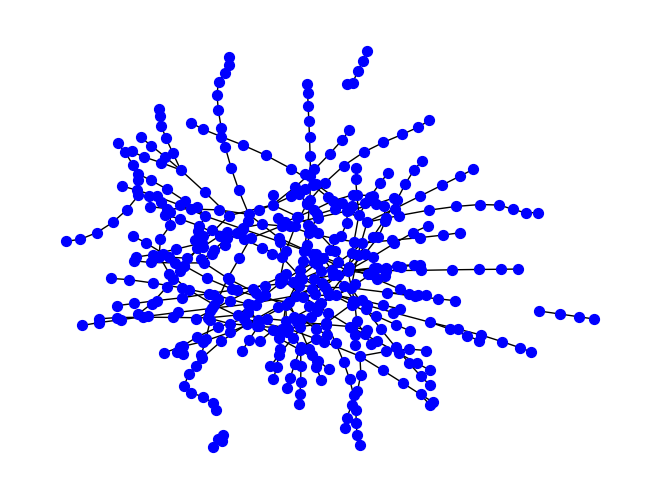

<Figure size 1200x1200 with 0 Axes>

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from operator import itemgetter

seed = 12345

# Initialize the graph
G_global = nx.Graph()

# Iterate through the dictionary and add nodes and edges
for article, first_link in global_article_links_dict.items():
    # Add nodes if they don't already exist
    if article not in G_global.nodes:
        G_global.add_node(article)
    if first_link not in G_global.nodes:
        G_global.add_node(first_link)

    # Add the edge between the current article and its first link
    G_global.add_edge(article, first_link)

print(str(G_global))
# # find node with largest degree
# node_and_degree = G_global.degree()
# (largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]

# print(str(largest_hub))
# # Create ego graph of main hub
# hub_ego = nx.ego_graph(G_global, largest_hub)

# Draw graph
# pos = nx.spring_layout(hub_ego, seed=seed)  # Seed layout for reproducibility
# nx.draw(hub_ego, pos, node_color="b", node_size=50, with_labels=False)
pos = nx.spring_layout(G_global, seed=seed)  # Seed layout for reproducibility
nx.draw(G_global, pos, node_color="b", node_size=50, with_labels=False)
# nx.draw_spectral(G_global)

# pos = nx.circular_layout(G_global)
# nx.draw(G_global, pos, node_size=20, alpha=0.5, node_color="blue", with_labels=False)
# plt.axis("equal")
plt.figure(figsize=(12, 12))
plt.show()

In [ ]:
# prompt: write global_article_links_dict to a tsv

import json

with open("global_article_links_dict.json", "r") as f:
    global_article_links_dict = json.load(f)

with open("global_article_links_dict.tsv", "w") as tsvfile:
    tsvfile.write("article\tfirst_link\n")
    for article, first_link in global_article_links_dict.items():
        tsvfile.write(f"{article}\t{first_link}\n")


# Network from 100 terms generated by ChatGPT

I outputted the dictionary as a TSV output for 100 terms plotted visualized, and played around with the data using the web app [Cosmograph](https://cosmograph.app/).  Here's a couple of screenshots:


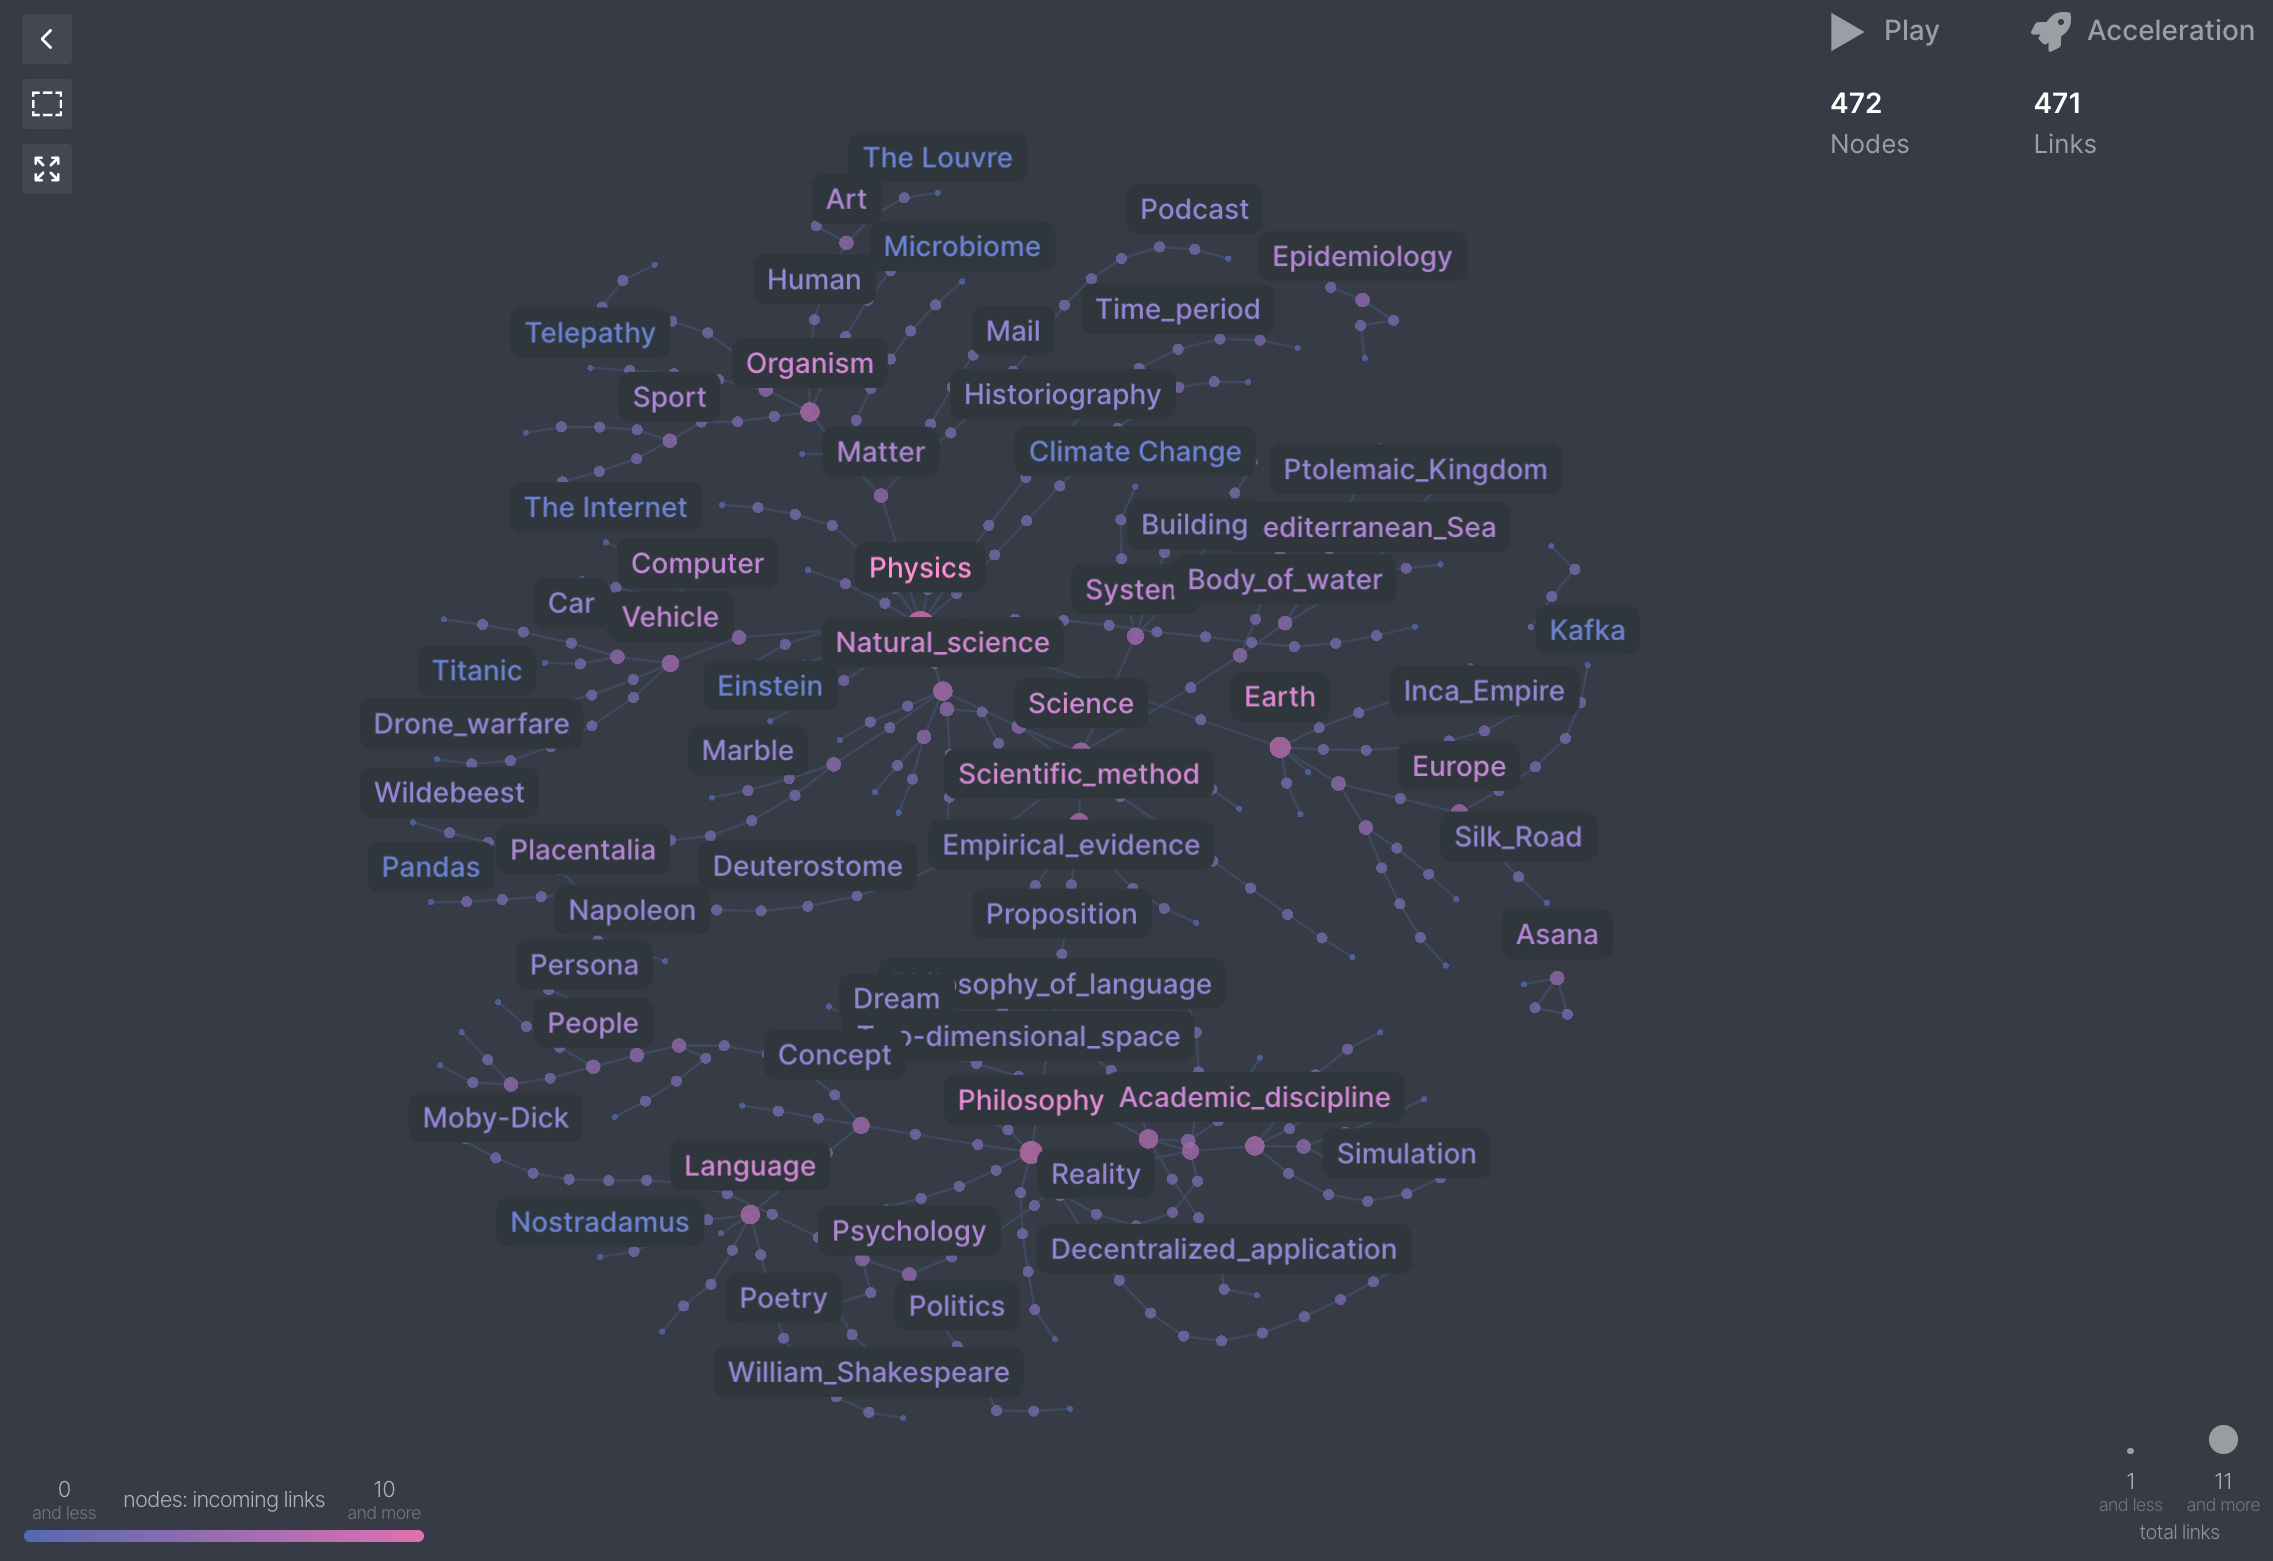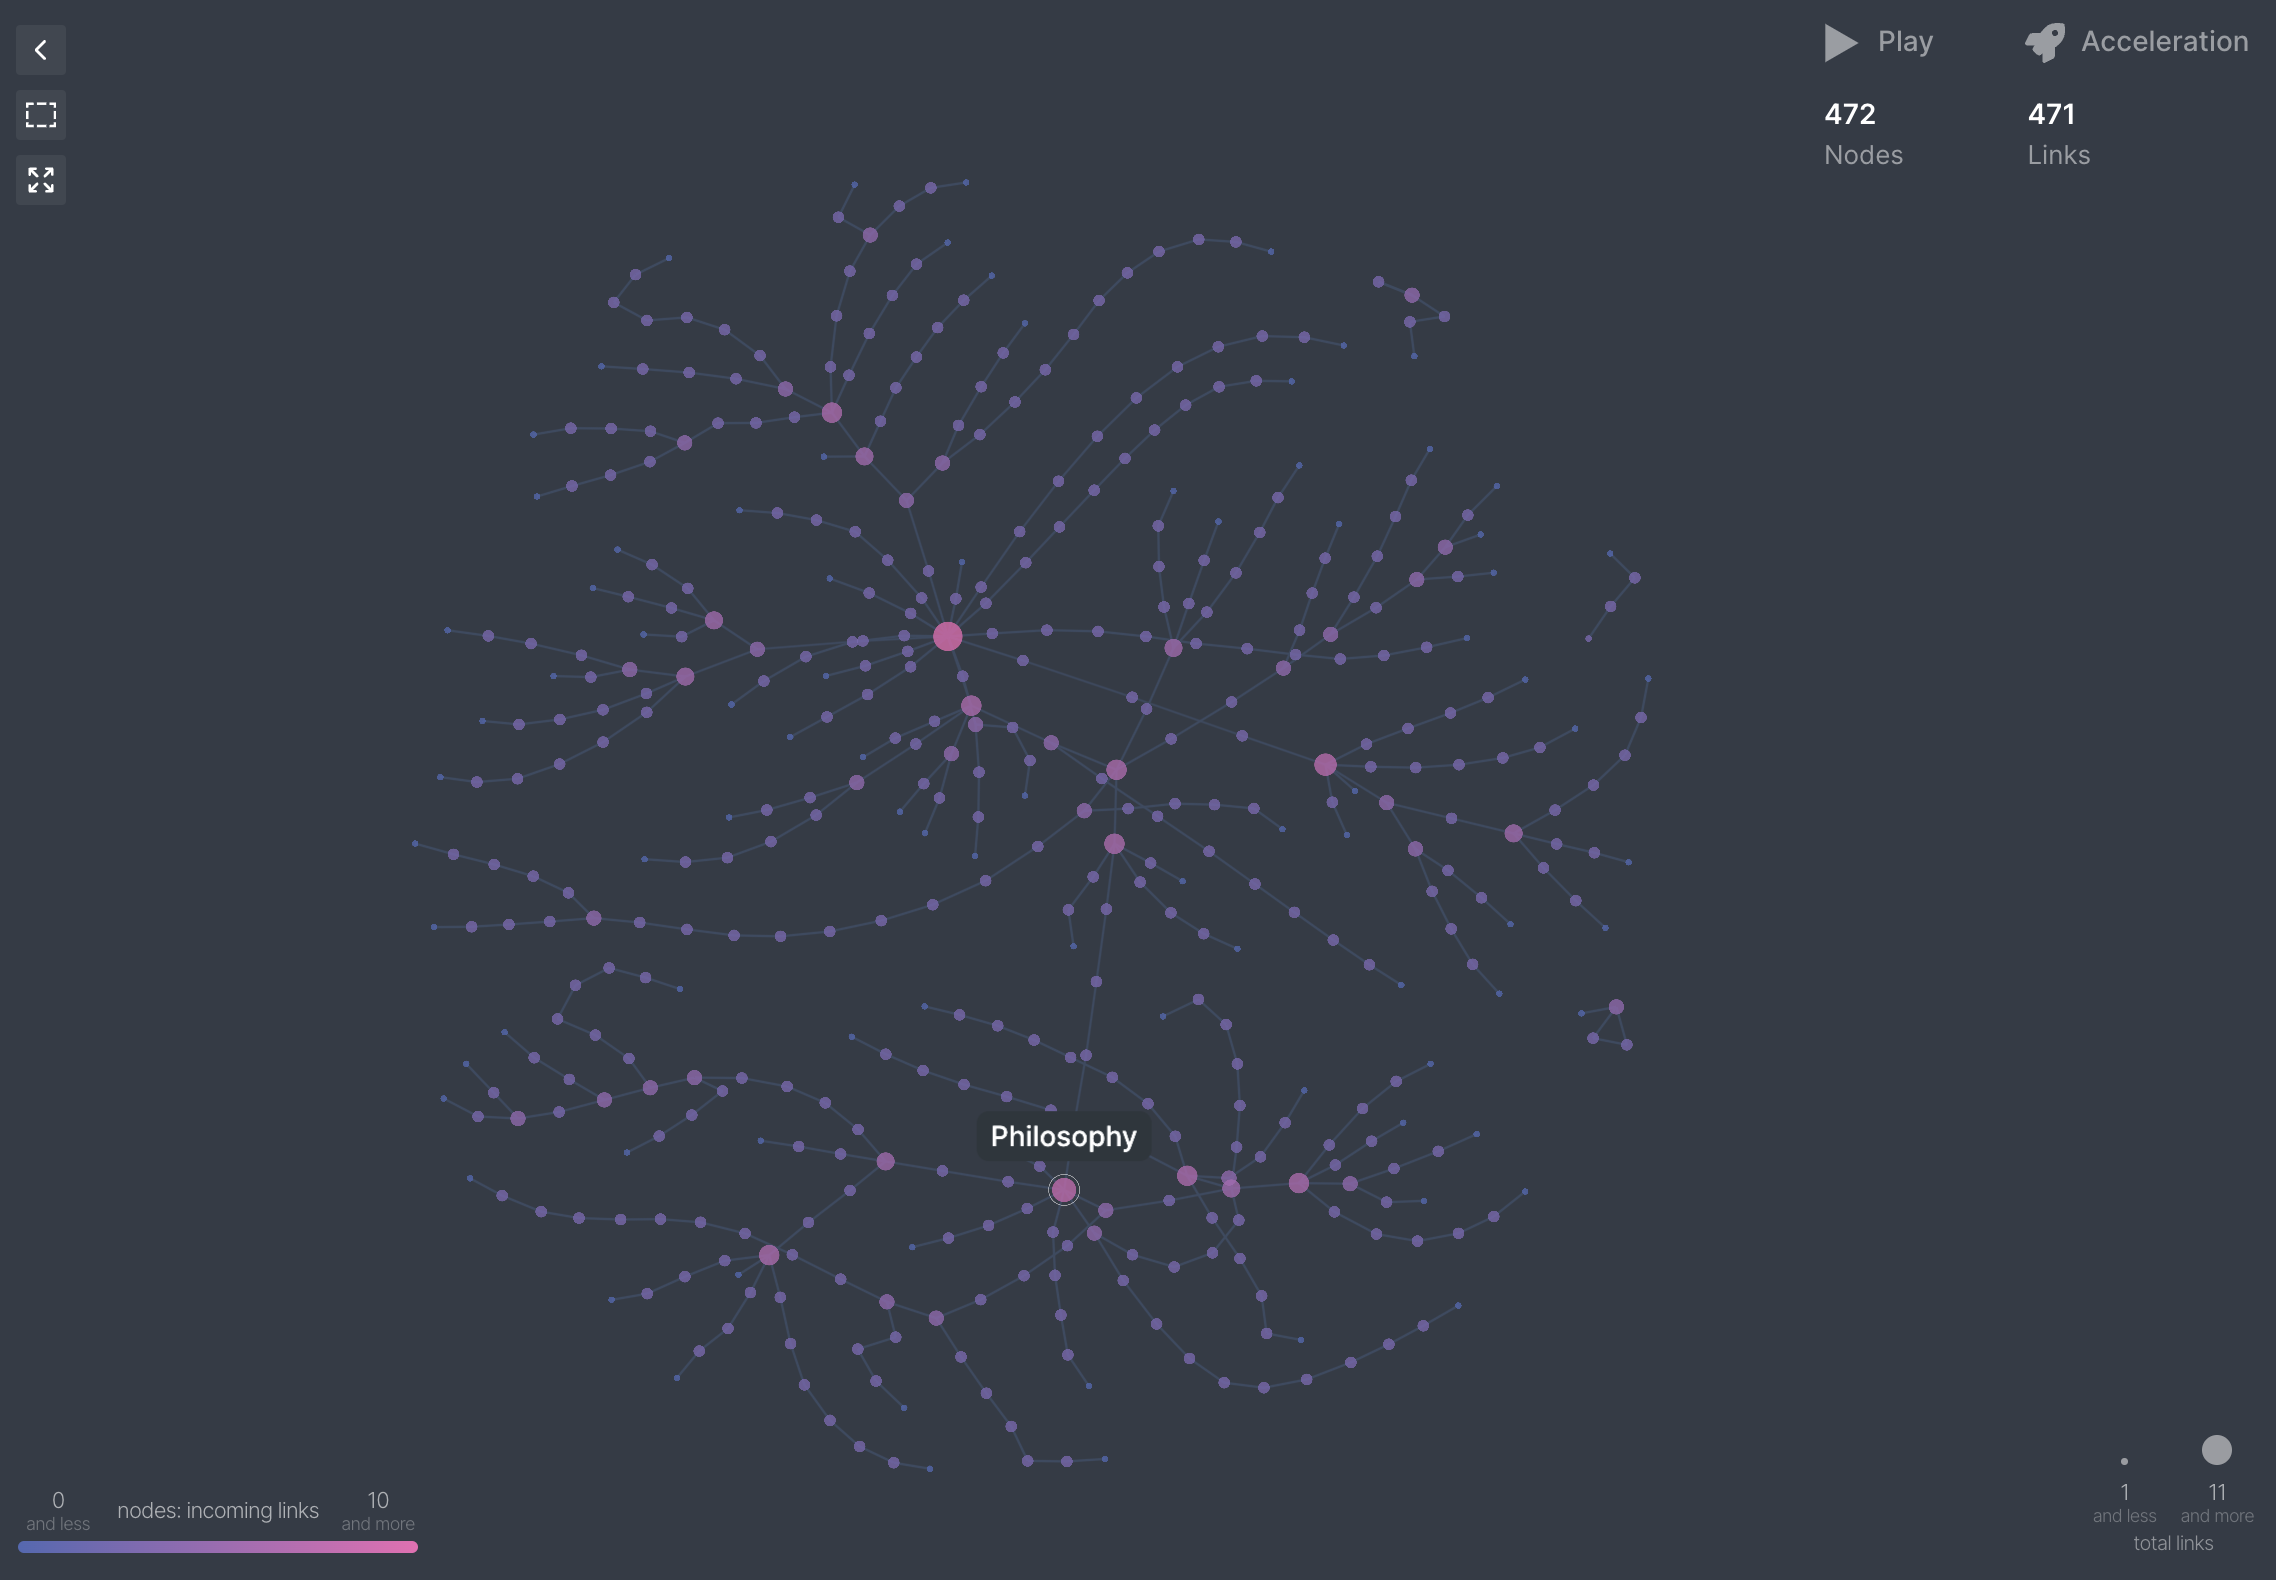